# 技能练度截图计算工具 (草稿) (完整演示)

## 环境

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import measure

## 0. 必要函数定义

In [2]:
# 定义图像之间差别
def image_diff(im_1, im_2, mask=None):
    """
    Variables
    ---------
    
    im_1, im_2: np.array
        Two images that need to be compared
    
    mask: np.array
        Mask on two images
        `Zero' or `False' value in mask means that we don't compare `im_1' and `im_2' at these pixels
    
    Note
    ----
    
    Shape of `im_1', `im_2', `mask' should be the same
    """
    if im_1.shape != im_2.shape: im_1 - im_2  # raise error here
    if mask is None:
        mask = np.zeros(im_1.shape) + 1
    return (np.abs((im_1 - im_2) * mask)).sum() / mask.sum()

In [3]:
# 寻找一条线上，低于阈值的部分的局域极小值在列表中的位置
def find_lmin(line, thresh=None):
    """
    Variables
    ---------
    
    line: np.array
        the line we want to find the local minimun
    
    thresh: float
        we just account the area that the line under than thresh
    
    Note
    ----
    
    All values in `line' should be larger than zero
    as well as `line' should be float and be acceptable for np.nan
    """
    if thresh is None: thresh = np.max(line)
    lmin = []
    line_mask = np.array(line<thresh, dtype=float)
    for i in range(len(line_mask)):
        if line_mask[i] == 0.: line_mask[i] = np.nan
    line_under_thresh = line * line_mask
    for i in range(2,len(line_under_thresh)-2):
        if (line_under_thresh[i] < line_under_thresh[i-1]) \
            and (line_under_thresh[i] < line_under_thresh[i+1]):
            lmin.append(i)
        elif line_under_thresh[i] == line_under_thresh[i]:  # include only one or two points under threshold; if two points, return the smaller one
            if not (line_under_thresh[i-1] == line_under_thresh[i-1]) and not (line_under_thresh[i+1] == line_under_thresh[i+1]):  # one point
                lmin.append(i)
            elif not (line_under_thresh[i-1] == line_under_thresh[i-1]) and not (line_under_thresh[i+2] == line_under_thresh[i+2]):  # nabn
                if line_under_thresh[i] <= line_under_thresh[i+1]: lmin.append(i)
            elif not (line_under_thresh[i+1] == line_under_thresh[i+1]) and not (line_under_thresh[i-2] == line_under_thresh[i-2]):  # nban
                if line_under_thresh[i] < line_under_thresh[i-1]: lmin.append(i)
    return lmin

In [4]:
# 确定单连通区域大小
def connect_area(mat, value):
    mat_bin = (mat == value)
    row_lower, row_upper, col_lower, col_upper = None, mat.shape[0]-1, None, mat.shape[1]-1
    for i in range(mat.shape[0]):
        if row_lower is None and mat_bin[i,:].any():
            row_lower = i
        if row_lower is not None and not mat_bin[i,:].any():
            row_upper = i-1
            break
    for i in range(mat.shape[1]):
        if col_lower is None and mat_bin[:,i].any():
            col_lower = i
        if col_lower is not None and not mat_bin[:,i].any():
            col_upper = i-1
            break
    if row_lower is None or col_lower is None:
        raise ValueError("Matrix imput contains no value required")
    return row_lower, row_upper, col_lower, col_upper

## 1. 从者位置确定

用户手动操作部分

In [5]:
# 技能图片
skill_path = "database/skill/skill_7.png"
# 储存从者与技能信息
dump_path = "skill_7.csv"

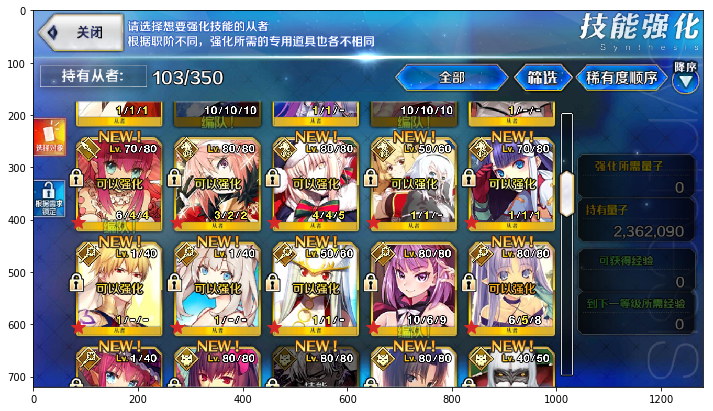

In [6]:
# 1. 读图
im_skill = plt.imread(skill_path)[:,:,:3]
if im_skill.shape[0] / im_skill.shape[1] != 0.5625:
    raise ValueError("Please import figures correctly!")
im_skill = resize(im_skill, (720,1280), mode="reflect")
# 2. 读定位标记
im_servant_indicator = []
im_servant_indicator.append(plt.imread("database/servant_indicator/gold.png")[:,:,:3])
im_servant_indicator.append(plt.imread("database/servant_indicator/silver.png")[:,:,:3])
im_servant_indicator.append(plt.imread("database/servant_indicator/bronze.png")[:,:,:3])
im_servant_indicator_mask = np.zeros(im_servant_indicator[0].shape)
im_servant_indicator_mask[:,:45,:] += 1
im_servant_indicator_mask[:,111:,:] += 1
# 3. 定位
servant_location = []
col_estimate = np.array([86, 274, 461, 649, 836])
row_index = range(309,720-19)
for i in col_estimate:
    for rarity in range(3):
        col_diff = np.array([image_diff(im_skill[j:j+19, i:i+158, :], im_servant_indicator[rarity], \
                                        im_servant_indicator_mask) for j in row_index ])
        col_lmin = find_lmin(col_diff, 0.07)
        for j in col_lmin:
            servant_location.append([i, j+309])
# 绘制结果
axs, fig = plt.subplots(figsize=(12,20))
plt.plot(np.array(servant_location).T[0], np.array(servant_location).T[1], \
         color="C3", marker="*", markersize=15, linestyle="None")
fig.imshow(im_skill)

## 2. 确定从者信息

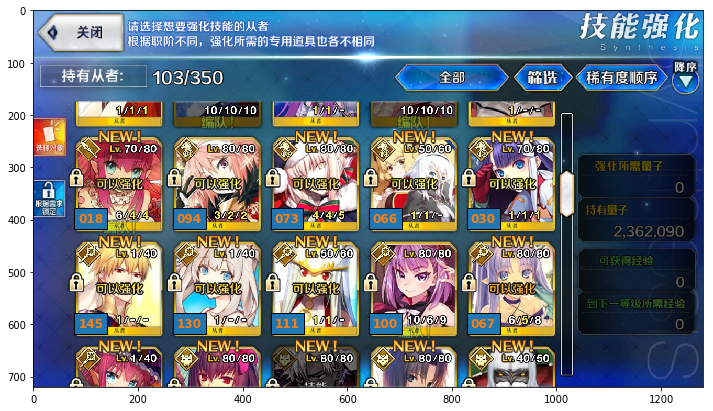

In [7]:
# 现在我们已经有了 im_skill 与 servant_location 信息了
# 字典 servent_dict 是你现在有的从者的所有信息
servant_dict = {}
im_servant_mask = plt.imread("database/servant_mask/mask.png")[:,:,:3]
for servant_loc in servant_location:
    servant_score = np.zeros(168)
    loc_row = servant_loc[1]; loc_col = servant_loc[0]
    im_servant_full = im_skill[loc_row-131:loc_row-1, loc_col+1:loc_col+157, :]
    for servant_ind in range(168):
        try:
            # since my database is RGBA; however we only want RGB, so truncate the 4th row of RGBA
            im_database = plt.imread("database/servant_database/" + "{:03d}".format(servant_ind) + ".png")[:,:,:3]
            servant_score[servant_ind] = image_diff(im_servant_full, im_database, mask=im_servant_mask)
        except:
            servant_score[servant_ind] = np.nan
    servant_ind = np.nanargmin(servant_score)
    servant_dict[servant_ind] = {}
    servant_dict[servant_ind]["location"] = servant_loc
# 绘制结果
axs, fig = plt.subplots(figsize=(12,20))
for servant_ind in servant_dict:
    plt.text(servant_dict[servant_ind]["location"][0], servant_dict[servant_ind]["location"][1], "{:03d}".format(servant_ind), \
             color="C1", weight="bold", bbox=dict(facecolor='C0'), fontsize=12)
fig.imshow(im_skill)

## 3. 读取技能练度

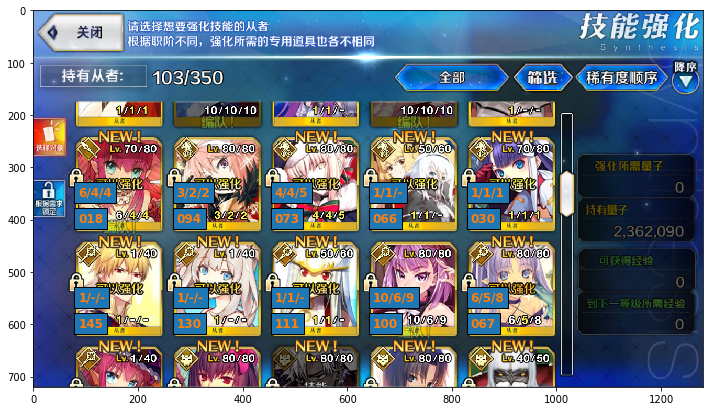

In [8]:
# 1. 数字数据库读入
im_number = []
im_number_mask = []
for i in range(10):
    im_tmp = plt.imread("database/numbers/" + "{:1d}".format(i) + ".png")
    im_number.append(im_tmp[:,:,0])
    im_number_mask.append(im_tmp[:,:,3])
im_tmp = plt.imread("database/numbers/slash.png")
im_number.append(im_tmp[:,:,0])
im_number_mask.append(im_tmp[:,:,3])
# 2. 定义默认的数字、字符的像素位置
label_odd = np.array([65, 77, 90, 102, 115, 127, 140])
label_even = np.array([71, 83, 96, 108, 121, 133])
# -- 初始定义结束，开始从者部分的循环
for servant_ind in servant_dict:
    # 3. 抽提从者的技能练度部分的图像
    loc_row = servant_dict[servant_ind]["location"][1]; loc_col = servant_dict[servant_ind]["location"][0]
    im_servant_skill = rgb2gray(im_skill[loc_row-22:loc_row-5, loc_col+1:loc_col+157, :]) > 0.4
    # 4. 读取单连通区域并作标签
    im_servant_skill_labels = measure.label(im_servant_skill, background=0, connectivity=1)
    # 5. 读取可能是数字的单连通区域并建立字典
    servant_skill_dict = {}
    servant_skill_dict["label"] = {}
    for i in range(1, im_servant_skill_labels.max()+1):
        row_lower, row_upper, col_lower, col_upper = connect_area(im_servant_skill_labels, i)
        if (5 <= (col_upper - col_lower + 1) <= 12) and (14 <= (row_upper - row_lower + 1) <= 17):
            servant_skill_dict["label"][i] = {}
            servant_skill_dict["label"][i]["boundary"] = (row_lower, row_upper, col_lower, col_upper)
            servant_skill_dict["label"][i]["center"] = (col_upper + col_lower) / 2
    # 6. 判断是否存在明显不合理单连通区域
    servant_skill_dict_pop_queue = []
    for i, j in servant_skill_dict["label"].items():
        if j["center"] <= 55 or j["center"] >= 143:
            servant_skill_dict_pop_queue.append(i)
    for i in servant_skill_dict_pop_queue:
        servant_skill_dict["label"].pop(i)
    # 7. 判断奇偶模式
    if np.array([ np.abs(label_odd-i["center"]).min() for _, i in servant_skill_dict["label"].items() ]).sum() \
        < np.array([ np.abs(label_even-i["center"]).min() for _, i in servant_skill_dict["label"].items() ]).sum():
        servant_skill_dict["mode"] = "odd"
        label_mode = label_odd
    else:
        servant_skill_dict["mode"] = "even"
        label_mode = label_even
    # 8. 剔除不符合奇偶模式的单连通区域
    servant_skill_dict_pop_queue = []
    for i, j in servant_skill_dict["label"].items():
        if np.abs(label_mode-j["center"]).min() >= 3:
            servant_skill_dict_pop_queue.append(i)
            continue
        servant_skill_dict["label"][i]["location"] = np.abs(label_mode-j["center"]).argmin()
    for i in servant_skill_dict_pop_queue:
        servant_skill_dict["label"].pop(i)
    # 9. 对每个 servant_skill_dict 的项，进行数字识别
    #    对于无法识别出的数字，剔除
    servant_skill_dict_pop_queue = []
    for i, j in servant_skill_dict["label"].items():
        number_compare_score = np.zeros(10)  # score of the number likewise
        for number in range(10):
            number_diff = []
            for pixel_left in range(j["boundary"][2]-3, j["boundary"][2]+2):
                number_diff.append( \
                    image_diff(im_servant_skill_labels[:, pixel_left:pixel_left+im_number[number].shape[1]]==i, \
                               im_number[number] * im_number_mask[number], \
                               mask = (np.zeros(im_number[number].shape)+1) ) \
                )
            number_compare_score[number] = np.array(number_diff).min()
        if number_compare_score.min() > 0.3:  # probably not a number, perhaps slash; delete from dictionary
            servant_skill_dict_pop_queue.append(i)
            continue
        # return the recognized number back to dictionary
        servant_skill_dict["label"][i]["number"] = number_compare_score.argmin()
        # 9.5. 对数字为 1, 5, 6, 8 的情形作 Double Check
        #      方法仍然是通过连通区域的大小来判断数值大小，覆盖方才进行的数字识别的结果
        if number_compare_score.argmin() in [1, 5, 6, 8, 9]:
            (row_lower, row_upper, col_lower, col_upper) = servant_skill_dict["label"][i]["boundary"]
            im_current_number = 1 - (im_servant_skill_labels[row_lower:row_upper+1, col_lower-1:col_upper+2]==i) * 1
            im_check_568_labels = measure.label(im_current_number, background=0, connectivity=2)
            if im_check_568_labels.max() <= 2: 
                if number_compare_score[1] <= number_compare_score[5]:  # if score of 1 and 5 are equal to each other, give 1
                    servant_skill_dict["label"][i]["number"] = 1
                else:
                    servant_skill_dict["label"][i]["number"] = 5
            elif im_check_568_labels.max() == 3: 
                if number_compare_score[6] <= number_compare_score[9]:  # if score of 6 and 9 are equal to each other, give 6
                    servant_skill_dict["label"][i]["number"] = 6
                else:
                    servant_skill_dict["label"][i]["number"] = 9
            elif im_check_568_labels.max() >= 4: 
                servant_skill_dict["label"][i]["number"] = 8
        servant_skill_dict["label"][i]["number_str"] = str(servant_skill_dict["label"][i]["number"])
    for i in servant_skill_dict_pop_queue:
        servant_skill_dict["label"].pop(i)
    # 10. 最终技能等级确定
    servant_skill_str_list = [" "] * len(label_mode)
    for i, j in servant_skill_dict["label"].items():
        servant_skill_str_list[j["location"]] = j["number_str"]
    servant_skill = []
    for i in "".join(servant_skill_str_list).split():
        if int(i) > 10:
            # -- TRICK!! Zero is very easily to be recognized as 6 or 9.
            #            If that happens, we just change make 16 and 19 to be 10
            #            That won't change the result too much, since no skill level higher than 10
            servant_skill.append(10)
        else:
            servant_skill.append(int(i))
    while len(servant_skill)<3:
        servant_skill.append(None)
    # 11. 技能字符串
    servant_skill_str = []
    for i in servant_skill:
        try:
            servant_skill_str.append(str(int(i)))
        except:
            servant_skill_str.append("-")
    servant_skill_str = "/".join(servant_skill_str)
    # 12. 写入数据回到从者信息
    servant_dict[servant_ind]["skill"] = servant_skill
    servant_dict[servant_ind]["skill_str"] = servant_skill_str
# 13. 绘制结果
axs, fig = plt.subplots(figsize=(12,20))
for servant_ind in servant_dict:
    plt.text(servant_dict[servant_ind]["location"][0], servant_dict[servant_ind]["location"][1], "{:03d}".format(servant_ind), \
             color="C1", weight="bold", bbox=dict(facecolor='C0'), fontsize=12)
    plt.text(servant_dict[servant_ind]["location"][0], servant_dict[servant_ind]["location"][1]-50, servant_dict[servant_ind]["skill_str"], \
             color="C1", weight="bold", bbox=dict(facecolor='C0'), fontsize=12)
fig.imshow(im_skill)

## 4. 储存到文件

In [9]:
with open(dump_path, "w") as dump_file:
    dump_file_text = ["从者序号,技能 1,技能 2,技能 3"]
    for i, j in servant_dict.items():
        dump_file_text.append(str(i) + "," + ",".join([str(k) for k in j["skill"] if k is not None]))
    dump_file_text = "\n".join(dump_file_text) + "\n"
    dump_file.write(dump_file_text)